In [1]:
import sys
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import numpy as np
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

sys.path.append('../modules')
import cw3ecmaps as cw3e

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [27]:
## six communities
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.8894, 59.3988, Klukwan
# -139.671	59.5121, Yakutat (PAYA)
# -133.1358, 55.4769, Craig
# -132.4009, 55.5400, Kasaan

xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go

## closest station
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.5117	59.2429, Haines (PAHN)
# -139.671	59.5121, Yakutat (PAYA)
# -133.076	55.5792, Klawock (PAKW)
# -131.7117	55.3567, Ketchikan (PAKT)
xs2 = [-135.4519, -135.3277, -135.5117, -139.671, -133.076, -131.7117]
ys2 = [58.1122, 59.4538, 59.2429, 59.5121, 55.5792, 55.3567]
lbl2 = ['PAOH', 'PAGY', 'PAHN', 'PAYA', 'PAKW', 'PAKT']

ext1 = [-140.5, -130., 54., 61.] # extent of SEAK 
ext1 = [-165., -130., 54., 62.] # extent of South southeast coast
ext1 = [-175., -151., 54., 72.] # extent of AK 

ext = ext1

In [19]:
%%time
url = 'http://nomads.ncep.noaa.gov:80/dods/gefs/gefs20230711/gec00_00z_pgrb2b'
ds = xr.open_dataset(url, decode_times=False)
ds = ds.isel(time=0, ens=0)
ds = ds.assign_coords({"lon": (((ds.lon + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
landsfc = ds['landsfc']
landsfc

CPU times: user 196 ms, sys: 12.7 ms, total: 209 ms
Wall time: 1.67 s


<xarray.DataArray 'landsfc' (lat: 361, lon: 720)>
[259920 values with dtype=float32]
Coordinates:
    ens      float64 1.0
    time     float64 7.387e+05
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... -2.5 -2.0 -1.5 -1.0 -0.5
Attributes:
    long_name:  ** surface land cover (0=sea, 1=land) [proportion]

In [20]:
## get topo
fname = '/work/bkawzenuk_work/Maps/data/ETOPO1_Bed_c_gmt4.grd'
datacrs = ccrs.PlateCarree()
grid = xr.open_dataset(fname)

grid = grid.interp(x=landsfc.lon.values, y=landsfc.lat.values) # regrid topo to match horizontal resolution of GEFS
grid = grid.where(grid.z > 0) # mask below sea level
# grid = grid.sel(x=slice(ext[0], ext[1]), y=slice(ext[2], ext[3]))

In [29]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
xticks = np.arange(ext[2],ext[3]+0.5,0.5)
yticks = np.arange(ext[0]+0.5,ext[1]+0.5,0.5)

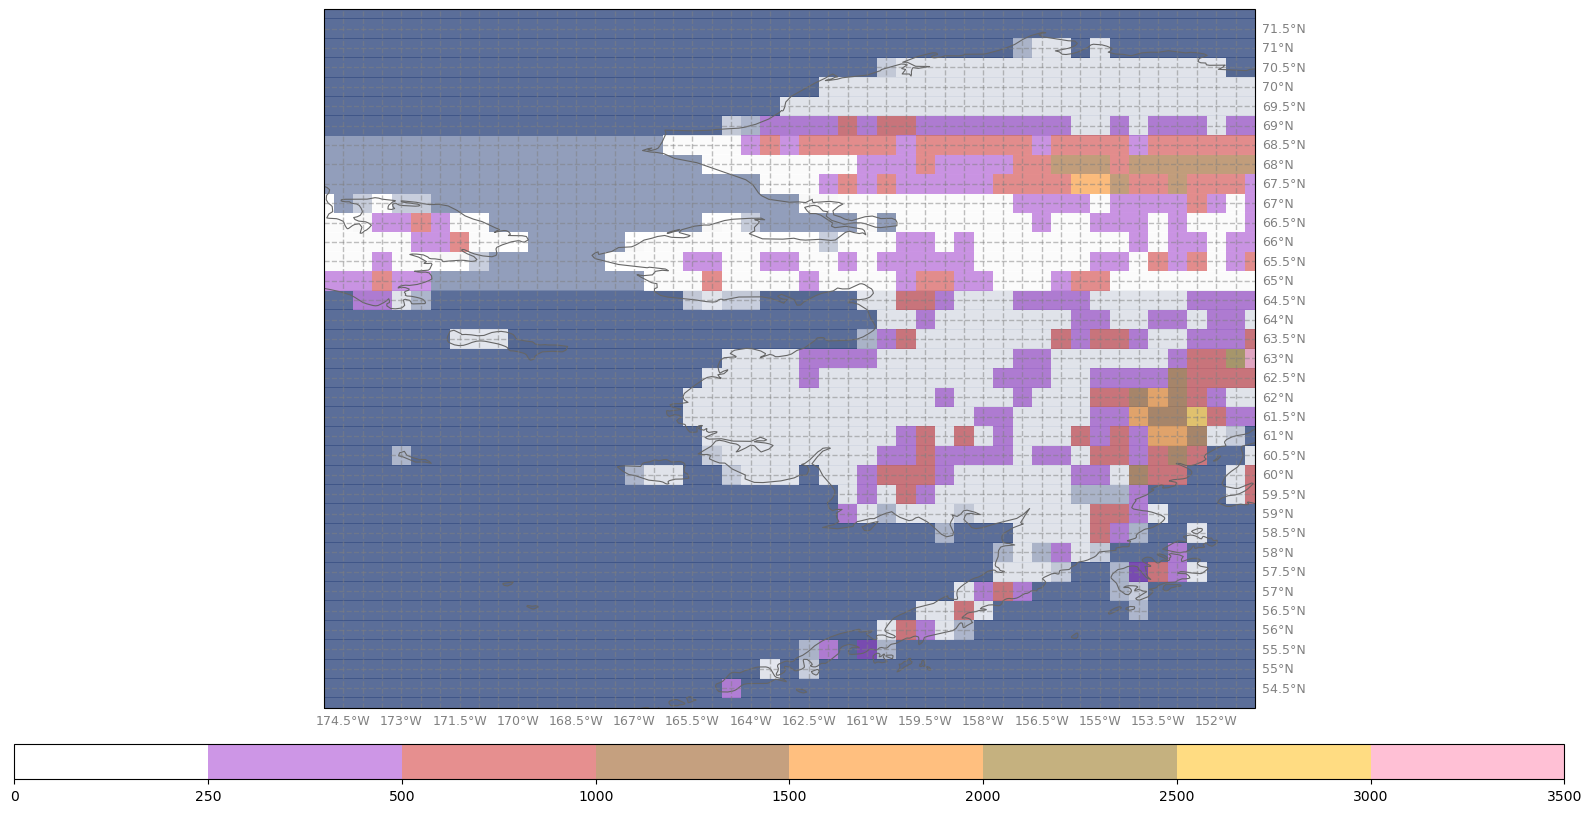

In [30]:

fig = plt.figure(figsize=(20, 10))
# ax = fig.axes(projection=mapcrs)
gs = GridSpec(2, 1, height_ratios=[1, 0.05], width_ratios = [1], hspace=0.1)
ax = fig.add_subplot(gs[0,0], projection=mapcrs)
ax.set_extent(ext, crs=datacrs)

# Add map features (continents and country borders)
ax.add_feature(cfeature.LAND, facecolor='0.9')      
ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)

## Add ERA-Interim Gridlines and Labels
gl = ax.gridlines(crs=datacrs, draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(yticks)
gl.ylocator = mticker.FixedLocator(xticks)
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}

# ax.set_yticks(yticks, crs=ccrs.PlateCarree()) # add external yticks
# plt.yticks(color='w', size=1) # hack: make the ytick labels white so they don't show up
# ax.set_xticks(xticks, crs=ccrs.PlateCarree()) # add external yticks
# plt.xticks(color='w', size=1) # hack: make the ytick labels white so they don't show up


#     ## Add ERA5 Gridlines
#     gl = ax.gridlines(crs=datacrs, draw_labels=True,
#                       linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
#     gl.xlines = True
#     gl.ylines = True
#     gl.xlocator = mticker.FixedLocator(np.arange(ext[2],ext[3]+0.25,0.25))
#     gl.ylocator = mticker.FixedLocator(np.arange(ext[0]+0.25,ext[1]+0.25,0.25))
#     gl.top_labels = False
#     # gl.bottom_labels = False
#     gl.left_labels = False
#     # gl.right_labels=True
#     gl.xformatter = LongitudeFormatter()
#     gl.yformatter = LatitudeFormatter()
#     gl.xlabel_style = {'size': 9, 'color': 'gray'}
#     gl.ylabel_style = {'size': 9, 'color': 'gray'}

# need this to fix annotate transform
transform = datacrs._as_mpl_transform(ax)

## Plot the locations of the focus communities
# zip joins x and y coordinates in pairs
# for x,y,z,ha in zip(xs,ys, lbl1, lbl_align):

    # Plot Location of pts
    # ax.plot(x, y, 'ro', markersize=6, transform=datacrs)

    # ax.annotate(z, # this is the text
    #            (x,y), # these are the coordinates to position the label
    #             textcoords="offset points", # how to position the text
    #             xytext=(0,12), # distance from text to points (x,y)
    #             ha=ha, # horizontal alignment can be left, right or center
    #             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=0.5, alpha=0.8),
    #             xycoords=transform,
    #             zorder=102,
    #             fontsize=14)
## add land/sea mask
cmap, norm, bnds = cw3e.cmap('land_sea')
cs = ax.pcolormesh(landsfc.lon, landsfc.lat, landsfc.values, cmap=cmap, norm=norm, rasterized=True, transform=datacrs, alpha=0.5)
                             
## add terrain
cmap, norm, bnds = cw3e.cmap('test_terrain')
cs = ax.pcolormesh(grid.x, grid.y, grid.z, cmap=cmap, norm=norm, rasterized=True, transform=datacrs, alpha=0.5)



## Add color bar
cbax = plt.subplot(gs[-1,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cs, orientation = 'horizontal', ticklocation = 'bottom', ticks=bnds)

plt.show()

In [31]:
fname = '../figs/gridmap_AK'
fmt = 'png'
fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)